In [1]:
import sys
sys.path.append('..')

In [46]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [3]:
import seaborn
%matplotlib inline

In [37]:
validation_set = pd.read_pickle("../data/geo-annotation/geo-characteristics-tissue-series.py3.pickle")
validation_set = pd.DataFrame(dict(classes=validation_set.groupby('series')['oid'].apply(list)))
validation_set['id'] = validation_set.index.map(lambda s: int(s[3:]))
validation_set.set_index('id', inplace=True)

validation_set_ids = [int(s) for s in validation_set.index.tolist()]

validation_set[:10]

,classes
id,
10213,[BTO:0000089]
10220,[BTO:0000089]
10306,[BTO:0001129]
10358,[BTO:0000141]
10402,[BTO:0000269]
10547,[BTO:0000149]
10612,[BTO:0000089]
10802,[BTO:0001422]
10846,[BTO:0000784]


In [48]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/brenda-tissue-ontology.obo',
                         exclude_duplicates=True,
                         subgraph='BTO:0001489')

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 5659
Number of edges: 6430
Average in degree:   1.1362
Average out degree:   1.1362


In [15]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [49]:
import_ontology(ontology, 'tissue_ontology')
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'tissue_ontology'), list(ontology.items()))

In [22]:
annotation_result_file = '../data/geo-annotation/series.tissue.res2.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='series',
                         ids=validation_set_ids
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [23]:
len(res)

1646

In [96]:
def doid_id(item_id):
    return "BTO:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'BTO:0001489', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [ ]:
# cell_type_cancer = 'DOID:0050687'
# organ_system_cancer = 'DOID:0050686'
# cell_type_benign_neoplasm = 'DOID:0060084'
# organ_system_benign_neoplasm = 'DOID:0060085'

# @pymonad.curry
# def exclude_similar_branches(ontology, classes):
#     has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
#     if has_osc:
#         return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
# #                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
# #                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
#                ]
#     else:
#         return classes

In [25]:
root_disease = 'BTO:0001489'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 4
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [99]:
results = pd.DataFrame(dict(
        odinary=res.classes,
        collapsed=res.classes.map(
                                  collapse_matches(ontology.graph)),
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(collapse_matches(syn_ontology.graph) *
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
        
#         syn=res.classes.map(collapse_matches(syn_ontology.graph)),

        validation=validation_set.classes,
        
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112642160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1145fabe0>]], dtype=object)

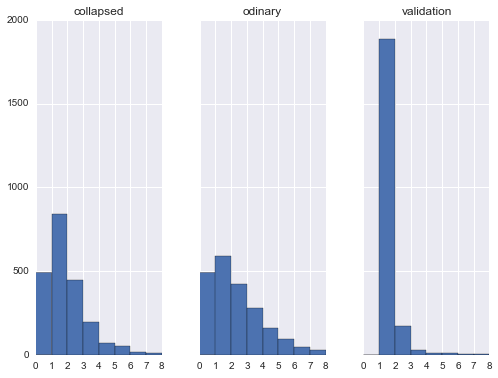

In [100]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 5),
                        figsize=(14, 6))
)

In [92]:
def cell():
    t = perfect.join(results, lsuffix='_perf')
    return t[(~t.collapsed_syn_perf) & (t.collapsed_syn.map(lambda c: len(c)==1))]
errors = cell()

In [94]:
i = 0

2
collapsed_perf                False
collapsed_syn_perf            False
odinary_perf                  False
syn_perf                      False
collapsed             [BTO:0000759]
collapsed_syn         [BTO:0000759]
odinary               [BTO:0000759]
syn                   [BTO:0000759]
validation            [BTO:0000784]
Name: 6857, dtype: object


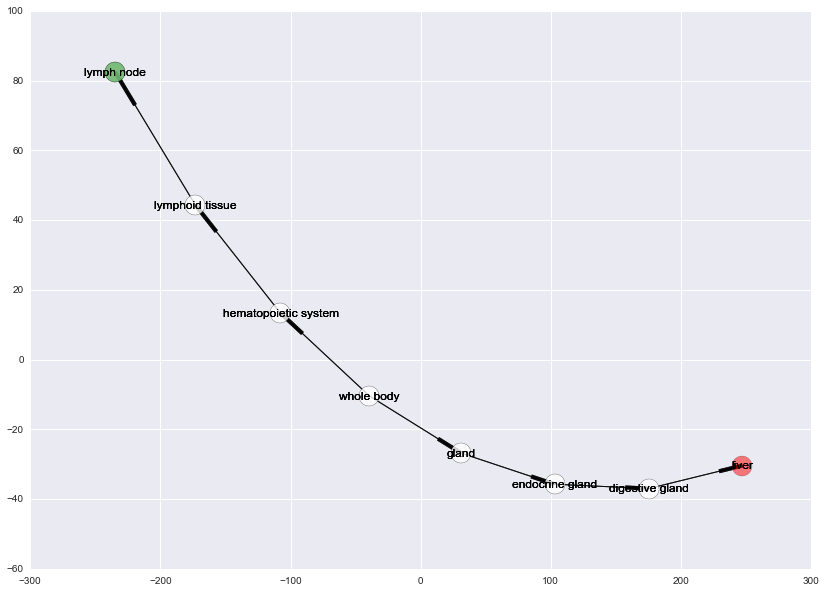

In [98]:
def cell():
    global i
    row = errors.iloc[i]
    print(i)
    print(row)
    i += 1
    matches_graph(row.collapsed_syn, row.validation)
    
cell()

In [81]:
def compare(rc, vc):
    return ontology.has_path(rc, vc)

def compare2(rc, vc):
    return ontology.has_path(rc, vc) or ontology.has_path(vc, rc)

def compare3(rc, vc):
    threshold = 4
    if rc == vc:
        return True
    return ontology.has_path(rc, vc) and (nx.shortest_path_length(ontology.graph, rc, vc) <= threshold)
                                
def compare4(rc, vc):
    if rc == vc:
        return True
    return compare3(rc, vc) or compare3(vc, rc)



@pymonad.curry
def cr(vd, res):
    return correct_ratio(res, vd, compare_func=compare4)

@pymonad.curry
def ir(vd, res):
    return incorrect_ratio(res, vd, compare_func=compare4)


@pymonad.curry
def pm(vd, res):
    return perfect_match(res, vd, compare_func=compare4)


def cell():
    global results
    correct = pd.DataFrame(data=dict([(c, cr(results.validation, results[c])) for c in results.columns if c != 'validation']))
    incorrect = pd.DataFrame(data=dict([(c, ir(results.validation, results[c])) for c in results.columns if c != 'validation']))
    perfect = pd.DataFrame(data=dict([(c, pm(results.validation, results[c])) for c in results.columns if c != 'validation']))
    return correct, incorrect, perfect
    
correct, incorrect, perfect = cell()

In [56]:
correct.mean()


collapsed        0.246544
collapsed_syn    0.643936
odinary          0.660252
dtype: float64

In [57]:
incorrect.mean()

collapsed        0.215492
collapsed_syn    0.316114
odinary          0.310050
dtype: float64

In [82]:
perfect.mean()

collapsed        0.598971
collapsed_syn    0.600374
odinary          0.400562
syn              0.552176
dtype: float64

## Сводная таблица

In [83]:
cols = [c for c in results.columns if c != 'validation']

counts = results.applymap(len).apply(lambda x: x.value_counts()).loc[1]
pd.DataFrame(dict(scores=[perfect.loc[results[results.validation.map(lambda x: len(x) == 1)].index].mean()[c] for c in cols],
                  counts=counts),
             index=cols).assign(range=lambda x: x['counts']/validation_set.shape[0])


,counts,scores,range
collapsed,841,0.633422,0.393542
collapsed_syn,887,0.635544,0.415068
odinary,592,0.423873,0.277024
syn,817,0.586207,0.382312
